In [1]:
#import pixiedust

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)
#sns.set(rc={'figure.figsize':(12,8)})

# Reading data

In [3]:
data = pd.read_csv('winemag-data_first150k.csv',index_col=0)
data.sample(5)

,country,description,designation,points,price,province,region_1,region_2,variety,winery
62355,US,Begins with pretty but light aromas of peaches...,NaN,83,14.0,California,Mendocino,Mendocino/Lake Counties,Pinot Blanc,Saint Gregory
53300,France,"This wine has distinct acidity, probably too m...",Les Champs Pimont Premier Cru,84,NaN,Burgundy,Beaune,NaN,Pinot Noir,Maison Champy
136507,Moldova,This wine starts off with robust aromas of pur...,Dionis,81,10.0,Moldova,NaN,NaN,Red Blend,Cricova
110497,US,"A bit heavy now, with lots of unintegrated par...",NaN,87,36.0,California,Napa Valley,Napa,Cabernet Sauvignon,M by Martellotto
10026,Italy,"Blue flower, underbrush, tobacco leaf, leather...",NaN,92,35.0,Southern Italy,Taurasi,NaN,Aglianico,Monte Faliesi


In [4]:
for c in data.columns:
    print(c,'='*(20-len(c)),data[c].unique().size)

country ============= 49
description ========= 97821
designation ========= 30622
points ============== 21
price =============== 358
province ============ 456
region_1 ============ 1237
region_2 ============ 19
variety ============= 632
winery ============== 14810


## Cleanup

In [5]:
# Drop columns that won't be used now
df = data.drop(columns=['description','designation','region_1','region_2','winery'])

In [6]:
# Keep only countries with more than 200 different wines
s = (df.country.value_counts()>200)
idx = s[s].index.tolist()
df = df[df.country.isin(idx)]

In [7]:
# Remove very expensive bottles
df = df[df.price<100]

In [8]:
for c in df.columns:
    print(c,'='*(20-len(c)),df[c].unique().size)

country ============= 15
points ============== 21
price =============== 96
province ============ 331
variety ============= 574


# Visualization

## Directly with pandas

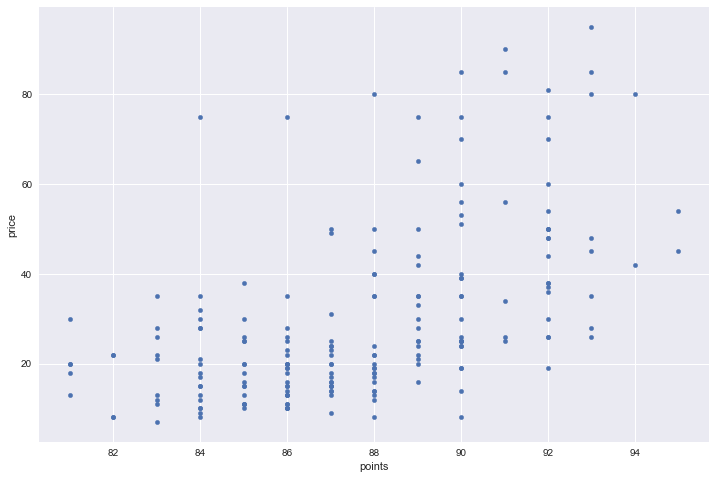

In [45]:
df.sample(200).plot.scatter(x='points',y='price');

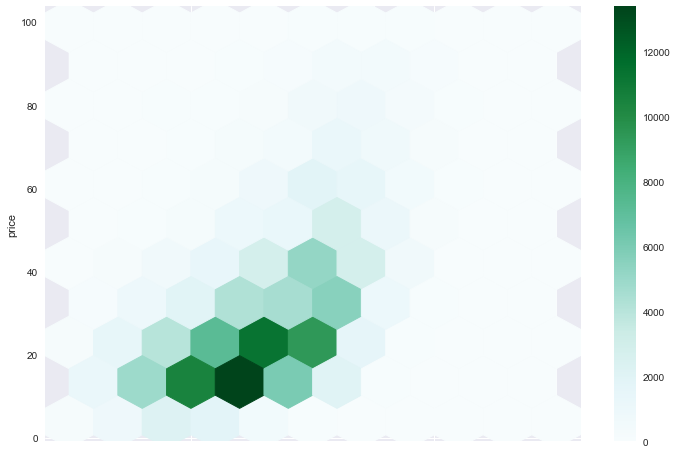

In [46]:
df.plot.hexbin(x='points',y='price',gridsize=10);

## Using Seaborn

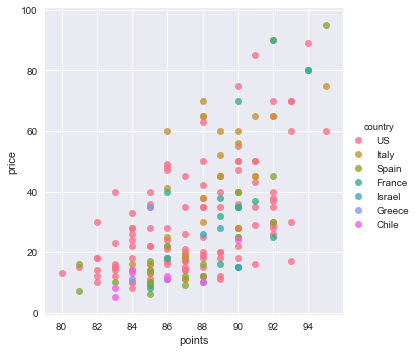

In [48]:
idx = df.country.isin(['US','France','Spain','Italy','Chile','Israel','Greece'])
sns.lmplot(x='points',y='price',data=df[idx].sample(200),
           fit_reg=False,
           hue='country',
           #hue_order=['France','US','Spain','Italy','Chile','Israel'],
           #palette='deep',
          );

# Machine Learning

In [49]:
from sklearn import tree, model_selection#, preprocessing

In [50]:
#le = preprocessing.LabelEncoder()
#le.fit_transform(y)

In [51]:
X = df[['country', 'price', 'province', 'variety']]
y = df['points']

## Splitting

In [124]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,train_size=0.8,random_state=123)
X_cv, X_test, y_cv, y_test = model_selection.train_test_split(X_test,y_test,train_size=0.5)

/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [125]:
print(X_train.shape,X_cv.shape,X_test.shape,y_train.shape,y_cv.shape,y_test.shape)

(105613, 4) (13202, 4) (13202, 4) (105613,) (13202,) (13202,)


## Encoding

In [74]:
#### Encoder from Alex Gbx

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.ensemble.partial_dependence import partial_dependence

class ImpactEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, col=None, m = 100,  new_col=None, k_fold = 4):
        self.col = col
        self.m = m
        self.new_col = new_col

    def fit(self, X, y=None):
            counts = X[self.col].value_counts()
            frequency = counts.apply(lambda x: float(x)/(float(x) + self.m))
            encoded_mean = pd.concat([X , y] ,axis =1).groupby(self.col)[y.name].agg(np.mean)
            mean = y.mean()
            def project(x):
                try:
                    return encoded_mean.loc[x]*frequency.loc[x] + (1-frequency.loc[x])*mean
                except:
                    return mean
            self.__transform = lambda data: data[self.col].apply(project).to_frame(name = self.new_col)
            return self

    def transform(self, X):
        try:
            return self.__transform(X)
        except AttributeError:
            print(" not fitted")


    def stacked_transform(self, X, y, seed = 2018):
        k_fold = 4
        kf = KFold(n_splits=k_fold, shuffle=True, random_state=seed)
        df_output = pd.DataFrame(columns = [self.col])
        for dev_index, val_index in kf.split(range(X.shape[0])):
                dev_X, val_X = X.iloc[dev_index,:], X.iloc[val_index,:]
                dev_y, val_y = y.iloc[dev_index], y.iloc[val_index]
                df_output = df_output.append(self.fit(dev_X, dev_y).transform(val_X))
        X = X.drop(self.col, axis = 1).join(df_output)
        return X

In [142]:
IEs = {}
for col in ['country', 'price', 'province', 'variety']:
    ie = ImpactEncoder(col=col).fit(X_train,y_train)
    IEs[col] = ie
    
IEs

{'country': ImpactEncoder(col='country', k_fold=None, m=100, new_col=None),
 'price': ImpactEncoder(col='price', k_fold=None, m=100, new_col=None),
 'province': ImpactEncoder(col='province', k_fold=None, m=100, new_col=None),
 'variety': ImpactEncoder(col='variety', k_fold=None, m=100, new_col=None)}

In [ ]:
def apply_impact(IE_dict,X,y):
    Xtemp = X
    for ie in IE_dict.values():
        Xtemp = ie.stacked_transform(Xtemp,y)
    return Xtemp

In [145]:
X_train_impact = apply_impact(IEs,X_train,y_train)
X_test_impact = apply_impact(IEs,X_test,y_test)

In [146]:
X_train_impact.head()

,country,price,province,variety
96097,87.714243,89.057106,88.426491,88.568994
139066,85.979911,85.553460,86.119312,87.250153
30321,88.172411,86.242648,88.231202,87.958205
11489,87.702412,86.550670,86.210729,86.641986
62996,87.714243,88.133061,87.562006,87.554071


In [147]:
X_test_impact.head()

,country,price,province,variety
113413,86.667278,85.554722,86.734118,87.515410
89841,87.690275,88.125467,87.643571,88.521988
28134,87.690275,89.258071,88.554911,87.267067
60514,87.701020,87.719651,87.490277,87.683284
129771,88.227988,85.920280,88.073672,88.198244


## Modelling

In [153]:
model1 = tree.tree.DecisionTreeRegressor()
model1.fit(X_train_impact,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [154]:
X_hat1 = model1.predict(X_test_impact)
X_hat1

array([ 86.        ,  83.33333333,  93.        , ...,  89.        ,
        89.        ,  86.        ])

In [155]:
(y_test-X_hat1).round().abs().sum()/y_test.size

2.7714740190880169

## XGBoost

In [106]:
import xgboost

In [156]:
model2 = xgboost.XGBRegressor()
model2.fit(X_train_impact,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [157]:
X_hat2 = model2.predict(X_test_impact)
X_hat2

array([ 85.4382782 ,  88.13455963,  89.7181778 , ...,  86.81293488,
        86.76133728,  86.92688751], dtype=float32)

In [158]:
(y_test-X_hat2).round().abs().sum()/y_test.size

2.0582487501893652

## CatBoost

In [188]:
from catboost import CatBoostRegressor

In [190]:
model3 = CatBoostRegressor()
model3.fit(X_train,y_train,cat_features=[0,1,2,3])

In [186]:
X_hat3 = model3.predict(X_test)
X_hat3

array([ 84.28500991,  85.60393252,  90.63289431, ...,  86.55303057,
        85.87669884,  86.48944603])

In [187]:
(y_test-X_hat3).round().abs().sum()/y_test.size

1.8435085593091955